# YouTube speech summarization with Whisper, Langchain & Azure Open AI

In the contemporary era, Azure OpenAI's Chat GPT has gained widespread recognition as a versatile tool. It boasts a range of capabilities, including generating content, translating languages, summarizing text, aiding in programming, and crafting narratives. Nonetheless, there exists a constraint regarding the volume of text that can be input into Chat GPT at a single instance, which hovers around 4096 tokens. Tokens can encompass words, sub-words, characters, or punctuation marks, and you can verify your text's token count by employing an online tokenizer.

When you encounter the need to condense documents that surpass this token threshold, you must divide them into smaller segments, ensuring each segment adheres to the token limit. These segments are then submitted to the model, and subsequently, the summaries are pieced together. This procedure can prove to be quite laborious, especially for exceptionally lengthy documents. Enter Langchain, which steps in to streamline this process through automation. We will now delve into the specifics of how Langchain accomplishes this task.

<img src="https://cdn.hashnode.com/res/hashnode/image/upload/v1695581465743/cbf6cd39-abad-47cc-9849-446ed2fd9cdd.png?auto=compress,format&format=webp" width=800>

In [2]:
import datetime
import openai
import os
import requests
import sys
import time
import tiktoken

from dotenv import load_dotenv
from IPython.display import YouTubeVideo
from langchain.chains import LLMChain
from langchain.chains import MapReduceDocumentsChain
from langchain.chains import ReduceDocumentsChain
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chat_models import AzureChatOpenAI
from langchain.document_loaders import TextLoader
from langchain.prompts import PromptTemplate
from langchain.text_splitter import TokenTextSplitter
from moviepy.editor import AudioFileClip
from pytube import YouTube

In [3]:
sys.version

'3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]'

In [4]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 09-Nov-2023 09:58:43


## Settings

In [5]:
load_dotenv("azure.env")

# Azure Open AI
openai.api_type: str = "azure"
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_base = os.getenv("OPENAI_API_BASE")
openai.api_version = os.getenv("OPENAI_API_VERSION")

print("Open AI version:", openai.__version__)

Open AI version: 0.28.1


In [6]:
GPT_MODEL = "gpt-35-turbo"
WHISPER_MODEL = "whisper"

In [7]:
def speech_to_text_azureopenai_whisper(audio_path):
    """
    Speech to text with Azure Open AI Whisper
    """
    start = time.time()

    # Prepare the headers
    headers = {
        "api-key": openai.api_key,
    }

    # Prepare the data for the multipart/form-data request
    json = {
        "file": (audio_path, open(audio_path, "rb"), "audio/mp3"),
        "locale": "en-US",
    }

    # Define the API endpoint URL
    url = f"{openai.api_base}/openai/deployments/{WHISPER_MODEL}/audio/transcriptions?api-version=2023-09-01-preview&"
    # Send the POST request
    response = requests.post(url, headers=headers, files=json)
    # Check the response
    if response.status_code == 200:
        print("Transcription request was successful.")
        transcription_data = response.json()

        elapsed = time.time() - start
        print(
            "Elapsed time: "
            + time.strftime(
                "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)
            )
        )
        return transcription_data
    else:
        print(f"Error: {response.status_code}")

In [8]:
output_directory = "audio"

os.makedirs(output_directory, exist_ok=True)

## Example 1

In [9]:
youtube_id = "U9mJuUkhUzk"
video_url = "https://www.youtube.com/watch?v=" + youtube_id

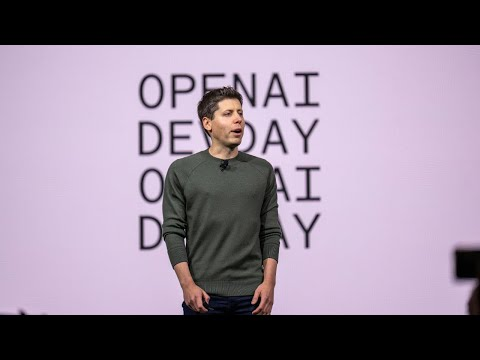

In [10]:
video = YouTubeVideo(youtube_id)
display(video)

In [11]:
audio_filename = f"audio_{youtube_id}.mp3"

yt = YouTube(video_url)
audio_stream = yt.streams.filter(only_audio=True).first()
audio_stream.download(output_path=output_directory, filename=audio_filename)
audio_path = os.path.join(output_directory, audio_filename)
print(f"Audio downloaded to {audio_path}")

Audio downloaded to audio/audio_U9mJuUkhUzk.mp3


In [12]:
!ls $audio_path -lh

-rwxrwxrwx 1 root root 16M Nov  7 11:28 audio/audio_U9mJuUkhUzk.mp3


### Speech to text

In [13]:
print("Running the Speech to text...")
transcript = speech_to_text_azureopenai_whisper(audio_path)
print("Done")

Running the Speech to text...
Transcription request was successful.
Elapsed time: 00:02:01.807347
Done


In [14]:
transcript_file = f"transcript_{youtube_id}.txt"

with open(transcript_file, "w") as file:
    file.write(transcript["text"])

text = transcript["text"]

In [15]:
text[:1000]

"Good morning. Thank you for joining us today. Please welcome to the stage Sam Altman. Good morning. Welcome to our first ever OpenAI Dev Day. We're thrilled that you're here and this energy is awesome. And welcome to San Francisco. San Francisco has been our home since day one. The city is important to us and the tech industry in general. We're looking forward to continuing to grow here. So we've got some great stuff to announce today. But first, I'd like to take a minute to talk about some of the stuff that we've done over the past year. About a year ago, November 30th, we shipped ChatGPT as a low-key research preview. And that went pretty well. In March, we followed that up with the launch of GPT-4. Still the most capable model out in the world. And in the last few months, we launched voice and vision capabilities so that ChatGPT can now see, hear, and speak. And more recently... There's a lot. You don't have to clap each time. And more recently, we launched Dolly 3, the world's mos

## Transcript file analysis with Map Reduce Langchain

In [16]:
!ls $transcript_file -lh

-rwxrwxrwx 1 root root 40K Nov  9 10:01 transcript_U9mJuUkhUzk.txt


In [17]:
duration_seconds = AudioFileClip(audio_path).duration
print(
    f"Audio file duration: {int(duration_seconds // 60)} minutes and {int(duration_seconds % 60)} seconds"
)

Audio file duration: 45 minutes and 35 seconds


In [18]:
len(text)

39991

In [19]:
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

In [20]:
with open(transcript_file, "r") as file:
    transcript = file.read()

In [21]:
tokens_integer = encoding.encode(transcript)
print(f"{len(tokens_integer)} are the number of tokens in transcript file")

9022 are the number of tokens in transcript file


## Summarization with map reduce langchain

In [22]:
# Map Chain
map_template = """Write a precise summary of this video transcript:

{content}

Summary:
"""

map_prompt = PromptTemplate.from_template(map_template)
llm = AzureChatOpenAI(deployment_name=GPT_MODEL)
map_chain = LLMChain(prompt=map_prompt, llm=llm)


# Reduce Chain
reduce_template = """The following is set of summaries:

{doc_summaries}

Summarize all the above summaries with all the key technical details.
Summary:"""

reduce_prompt = PromptTemplate.from_template(reduce_template)
reduce_chain = LLMChain(prompt=reduce_prompt, llm=llm)
stuff_chain = StuffDocumentsChain(
    llm_chain=reduce_chain, document_variable_name="doc_summaries"
)
reduce_chain = ReduceDocumentsChain(
    combine_documents_chain=stuff_chain,
)


# Map Reduce Chain
map_reduce_chain = MapReduceDocumentsChain(
    llm_chain=map_chain,
    document_variable_name="content",
    reduce_documents_chain=reduce_chain,
)

In [23]:
# Loading the transcript file
loader = TextLoader(transcript_file)
docs = loader.load()

# Split the content into smaller chuncks
splitter = TokenTextSplitter(chunk_size=4000)
split_docs = splitter.split_documents(docs)

In [24]:
nbchunks = len(split_docs)
print("Number of chunks =", nbchunks)

Number of chunks = 3


In [25]:
# Use Map reduce chain to summarize
summary = map_reduce_chain.run(split_docs)
print(summary)

In the video transcript of the OpenAI Dev Day presentation, CEO Sam Altman highlights the progress made by OpenAI over the past year. This includes the launch of ChatGPT, GPT-4, and advancements in voice and vision capabilities. Altman also mentions Dolly 3, showcasing the success and widespread use of OpenAI technologies.

The transcript goes on to discuss the improvements made to ChatGPT, specifically the integration of GPT-4 Turbo. This new version introduces features like web browsing, code writing, and image generation. Additionally, the transcript introduces the concept of GPTs, which are tailored versions of ChatGPT for specific purposes. Users can build, customize, and publish their own GPTs, such as Lesson Planner GPT, Design GPT, and Zapier GPT.

The video transcript further highlights the new capabilities of OpenAI's Assistance API. They demonstrate the Code Interpreter, which can generate and execute code on the fly, perform calculations, and generate files. The transcript 

In [26]:
# Saving the summary file
summary_file = f"summary_{youtube_id}.txt"

file = open(summary_file, 'w')
file.write(summary)
file.close()

!ls $summary_file -lh

-rwxrwxrwx 1 root root 1.4K Nov  9 10:02 summary_U9mJuUkhUzk.txt


## Another example

In [27]:
youtube_id = "9W9CpLK7I1c"
video_url = "https://www.youtube.com/watch?v=" + youtube_id

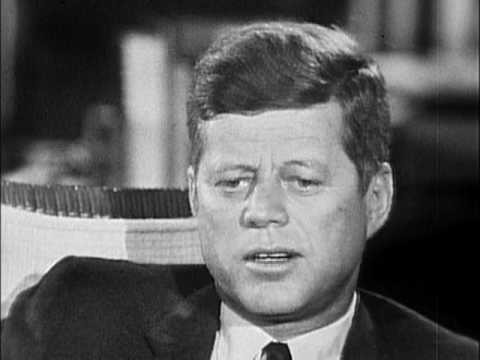

In [28]:
video = YouTubeVideo(youtube_id)
display(video)

In [29]:
audio_filename = f"audio_{youtube_id}.mp3"

yt = YouTube(video_url)
audio_stream = yt.streams.filter(only_audio=True).first()
audio_stream.download(output_path=output_directory, filename=audio_filename)
audio_path = os.path.join(output_directory, audio_filename)
print(f"Audio downloaded to {audio_path}")

Audio downloaded to audio/audio_9W9CpLK7I1c.mp3


In [30]:
print("Running the Speech to text...")
transcript = speech_to_text_azureopenai_whisper(audio_path)
print("Done")

Running the Speech to text...
Transcription request was successful.
Elapsed time: 00:01:09.453927
Done


In [31]:
transcript_file = f"transcript_{youtube_id}.txt"

with open(transcript_file, "w") as file:
    file.write(transcript["text"])

text = transcript["text"]

In [32]:
duration_seconds = AudioFileClip(audio_path).duration
print(
    f"Audio file duration: {int(duration_seconds // 60)} minutes and {int(duration_seconds % 60)} seconds"
)

Audio file duration: 25 minutes and 33 seconds


In [33]:
with open(transcript_file, "r") as file:
    transcript = file.read()

In [34]:
tokens_integer = encoding.encode(transcript)
print(f"{len(tokens_integer)} is the number of tokens in transcript file")

5450 is the number of tokens in transcript file


In [35]:
# Loading the transcript file
loader = TextLoader(transcript_file)
docs = loader.load()

# Split the content into smaller chuncks
splitter = TokenTextSplitter(chunk_size=4000)
split_docs = splitter.split_documents(docs)

# Use Map reduce chain to summarize
summary = map_reduce_chain.run(split_docs)
print(summary)

President Kennedy reflects on his first two years in office in a video transcript. He discusses the difficulties and limitations of the presidency, particularly in solving international problems, such as the situation in the Congo. He also talks about his struggles in passing bills through a divided Congress, particularly in the areas of education and civil rights. Kennedy defends his use of presidential power, specifically in regards to the rollback of steel prices, stating that he acted in the best interest of the public and to maintain good faith between labor and management. He emphasizes the importance of perseverance and the need for cooperation between the presidency and Congress.


In [36]:
# Saving the summary file
summary_file = f"summary_{youtube_id}.txt"

file = open(summary_file, 'w')
file.write(summary)
file.close()

!ls $summary_file -lh

-rwxrwxrwx 1 root root 696 Nov  9 10:03 summary_9W9CpLK7I1c.txt


## Last example

In [37]:
youtube_id = "uZcqUh7ciug"
video_url = "https://www.youtube.com/watch?v=" + youtube_id

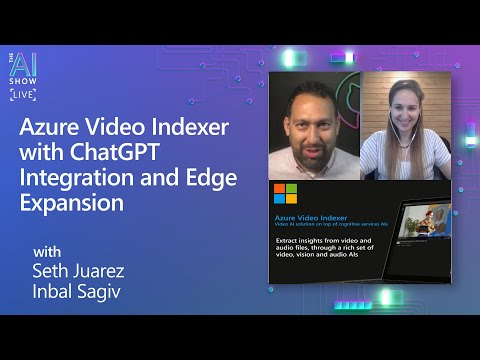

In [38]:
video = YouTubeVideo(youtube_id)
display(video)

In [39]:
audio_filename = f"audio_{youtube_id}.mp3"

yt = YouTube(video_url)
audio_stream = yt.streams.filter(only_audio=True).first()
audio_stream.download(output_path=output_directory, filename=audio_filename)
audio_path = os.path.join(output_directory, audio_filename)
print(f"Audio downloaded to {audio_path}")

Audio downloaded to audio/audio_uZcqUh7ciug.mp3


In [40]:
print("Running the Speech to text...")
transcript = speech_to_text_azureopenai_whisper(audio_path)
print("Done")

Running the Speech to text...
Transcription request was successful.
Elapsed time: 00:00:48.848497
Done


In [41]:
transcript_file = f"transcript_{youtube_id}.txt"

with open(transcript_file, "w") as file:
    file.write(transcript["text"])

text = transcript["text"]

In [42]:
duration_seconds = AudioFileClip(audio_path).duration
print(
    f"Audio file duration: {int(duration_seconds // 60)} minutes and {int(duration_seconds % 60)} seconds"
)

Audio file duration: 18 minutes and 34 seconds


In [43]:
with open(transcript_file, "r") as file:
    transcript = file.read()

In [44]:
tokens_integer = encoding.encode(transcript)
print(f"{len(tokens_integer)} is the number of tokens in transcript file")

3518 is the number of tokens in transcript file


In [45]:
# Loading the transcript file
loader = TextLoader(transcript_file)
docs = loader.load()

# Split the content into smaller chuncks
splitter = TokenTextSplitter(chunk_size=4000)
split_docs = splitter.split_documents(docs)

# Use Map reduce chain to summarize
summary = map_reduce_chain.run(split_docs)
print(summary)

The video discusses the features and capabilities of Azure Video Indexer, a tool that uses artificial intelligence (AI) to extract insights from videos. It can extract over 30 different AI insights, including text extraction, face recognition, object detection, and transcription. The tool offers benefits such as improved searchability, accessibility, content generation, and content moderation. It also integrates with Azure OpenAI and ChatGPT to enhance the search experience, allowing users to search through video transcripts using natural language queries. The video showcases a private preview feature that enables users to redact faces in videos using AI. It also provides a code sample for integrating Video Indexer with OpenAI and ChatGPT. The video discusses the expansion of Video Indexer to edge computing scenarios through the ARC platform, enabling customers to run AI processes close to their data centers. Users can access these features and provide feedback on the tool.


In [46]:
# Saving the summary file
summary_file = f"summary_{youtube_id}.txt"

file = open(summary_file, 'w')
file.write(summary)
file.close()

!ls $summary_file -lh

-rwxrwxrwx 1 root root 988 Nov  9 10:04 summary_uZcqUh7ciug.txt
